# Lab 9: Decision Trees and Random Forests
Objective: Learn Decision Trees, ID3, CART, and Random Forest, and apply them to real-world data

## Task 1: ID3 Decision Tree Implementation from Scratch on XOR dataset

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
# Entropy function
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

# Split dataset based on feature values
def split_dataset(X, y, feature, value):
    mask = X[:, feature] == value
    return X[mask], y[mask]

# Information Gain calculation
def information_gain(X, y, feature):
    base_entropy = entropy(y)
    unique_vals = np.unique(X[:, feature])
    feature_entropy = 0.0

    for value in unique_vals:
        X_subset, y_subset = split_dataset(X, y, feature, value)
        prob = len(y_subset) / len(y)
        feature_entropy += prob * entropy(y_subset)

    return base_entropy - feature_entropy

# ID3 Algorithm
def id3(X, y, feature_names):
    # If all target values are the same, return that value
    if len(np.unique(y)) == 1:
        return y[0]

    # If no features left to split, return most common label
    if len(feature_names) == 0:
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    # Find the best feature to split on
    best_feature = max(range(X.shape[1]), key=lambda f: information_gain(X, y, f))
    tree = {feature_names[best_feature]: {}}

    unique_vals = np.unique(X[:, best_feature])
    for value in unique_vals:
        # Split the dataset based on the best feature
        X_subset, y_subset = split_dataset(X, y, best_feature, value)

        # If X_subset is empty, we return the most common label
        if len(X_subset) == 0:
            values, counts = np.unique(y, return_counts=True)
            tree[feature_names[best_feature]][value] = values[np.argmax(counts)]
        else:
            # Remove the used feature from X and feature_names
            X_reduced = np.delete(X_subset, best_feature, axis=1)
            remaining_features = [f for i, f in enumerate(feature_names) if i != best_feature]

            # Recursively build the tree
            subtree = id3(X_reduced, y_subset, remaining_features)
            tree[feature_names[best_feature]][value] = subtree

    return tree

# Build logic gate datasets
def create_logic_gate_dataset(gate):
    if gate == "XOR":
        X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
        y = np.array([0, 1, 1, 0])
    return X, y

# Prediction function
def predict(tree, sample, feature_names):
    while isinstance(tree, dict):  # Traverse the tree until we reach a leaf node
        feature = next(iter(tree))
        feature_index = feature_names.index(feature)
        value = sample[feature_index]

        if value in tree[feature]:
            tree = tree[feature][value]  # Move to the next branch in the tree
        else:
            return None  # Return None if an unseen value is encountered

    return tree  # At this point, tree should be a leaf node with a numeric label

{'Input1': {0: {'Input2': {0: 0, 1: 1}}, 1: {'Input2': {0: 1, 1: 0}}}}

Predictions:
Input: [0 0], Prediction: 0
Input: [0 1], Prediction: 1
Input: [1 0], Prediction: 1
Input: [1 1], Prediction: 0


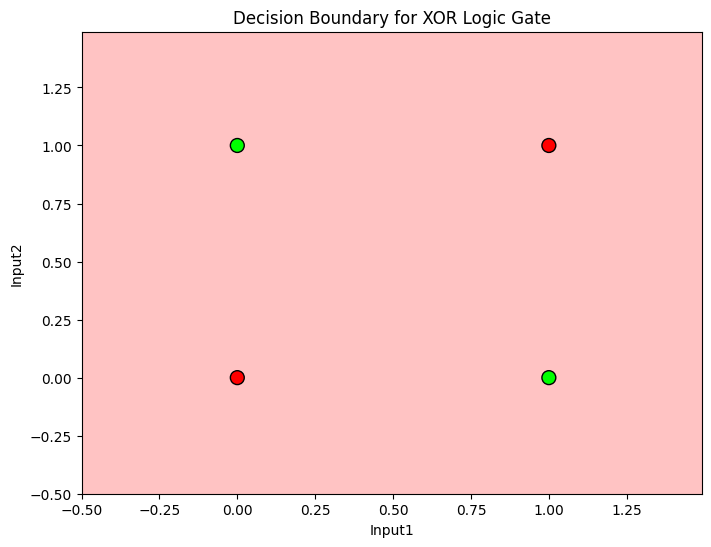

In [ ]:
# Testing and visualizing for XOR gate

X, y = create_logic_gate_dataset("XOR")
feature_names = ['Input1', 'Input2']

# Build and print the decision tree
tree = id3(X, y, feature_names)
print(tree)

# Make predictions
print("\nPredictions:")
samples = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
for sample in samples:
      prediction = predict(tree, sample, feature_names)
      print(f"Input: {sample}, Prediction: {prediction}")


# Visualization function for decision boundaries with error handling
def plot_decision_boundary(tree, feature_names, gate):
    # Create a grid of points to plot
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict for each point in the grid with error handling
    Z = []
    for sample in grid:
        prediction = predict(tree, sample, feature_names)
        # Ensure the prediction is a valid integer (0 or 1); default to 0 if not
        Z.append(prediction if isinstance(prediction, int) else 0)
    Z = np.array(Z).reshape(xx.shape)

    # Plot decision boundaries
    plt.figure(figsize=(8, 6))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)

    # Plot the original data points for the logic gate
    X, y = create_logic_gate_dataset(gate)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#00FF00']), edgecolor='k', s=100)
    plt.xlabel("Input1")
    plt.ylabel("Input2")
    plt.title(f"Decision Boundary for {gate} Logic Gate")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


    # Visualize decision boundaries
plot_decision_boundary(tree, feature_names, "XOR")

# Task 2: CART Decision Tree on moons dataset

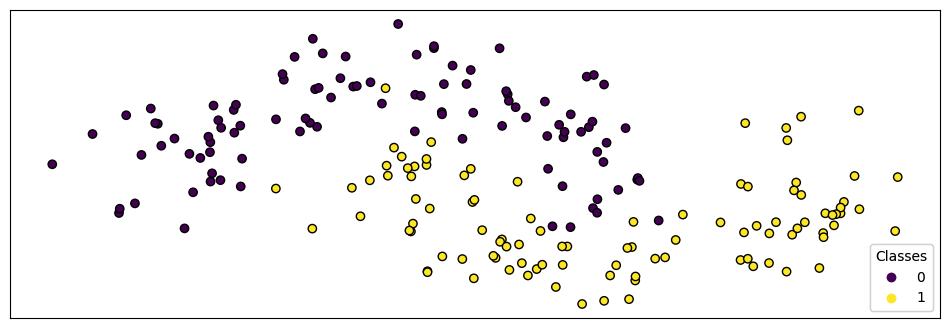

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
plt.figure(figsize=(12,4))
ax = plt.gca()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Classes")
ax.add_artist(legend1)
ax.set_xticks(())
ax.set_yticks(());

CART Tree from scratch

In [ ]:
# Gini impurity calculation
def gini(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum([p**2 for p in probabilities if p > 0])

# Information gain using Gini impurity
def gini_gain(X_column, y, threshold):
    parent_gini = gini(y)
    left_idxs = X_column < threshold
    right_idxs = X_column >= threshold
    n, n_left, n_right = len(y), sum(left_idxs), sum(right_idxs)
    if n_left == 0 or n_right == 0:
        return 0
    e_left, e_right = gini(y[left_idxs]), gini(y[right_idxs])
    child_gini = (n_left / n) * e_left + (n_right / n) * e_right
    return parent_gini - child_gini

# CART Decision Tree class
class CARTTree:
    def __init__(self, max_depth=10, max_features=None):
        self.max_depth = max_depth
        self.tree = None
        self.max_features = max_features


    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            unique_labels, counts = np.unique(y, return_counts=True)
            return unique_labels[np.argmax(counts)]


        best_gain = -1
        split_idx, split_threshold = None, None
        for feature_idx in range(num_features):
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = gini_gain(X_column, y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold

        if best_gain == 0:
            unique_labels, counts = np.unique(y, return_counts=True)
            return unique_labels[np.argmax(counts)]

        left_idxs = X[:, split_idx] < split_threshold
        right_idxs = X[:, split_idx] >= split_threshold
        left_subtree = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_subtree = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)
        return (split_idx, split_threshold, left_subtree, right_subtree)

    def _predict(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feature_idx, threshold, left, right = tree
        if x[feature_idx] < threshold:
            return self._predict(x, left)
        else:
            return self._predict(x, right)

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])

CART Decision Tree Accuracy on make_moons: 0.92


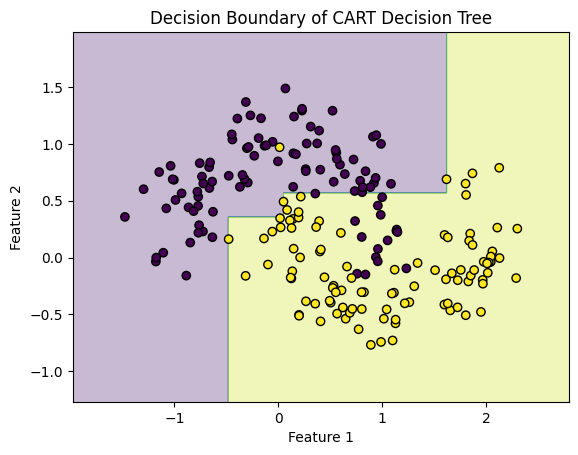

In [ ]:
# Train the CART Decision Tree on make_moons data
cart_tree = CARTTree(max_depth=4)
cart_tree.fit(X, y)

# Predict on training data
predictions = cart_tree.predict(X)

# Calculate accuracy
accuracy = np.mean(predictions == y)
print("CART Decision Tree Accuracy on make_moons:", accuracy)

# Visualization of decision boundaries
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary of CART Decision Tree")
    plt.show()

# Plot decision boundary
plot_decision_boundary(cart_tree, X, y)

# Task 3: Performance comparison of Decision Tree with Random Forest on Breast Cancer dataset

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Train the CART Decision Tree on make_moons data
cart_tree = CARTTree(max_depth=4)
cart_tree.fit(X_train, y_train)

# Predict on training data
predictions = cart_tree.predict(X_test)

# Calculate accuracy
accuracy = np.mean(predictions == y_test)
print("CART Decision Tree Accuracy on Breast Cancer Dataset:", accuracy)

CART Decision Tree Accuracy on Breast Cancer Dataset: 0.9532163742690059


Random Forest Implementation from Scratch

In [ ]:
# Random Forest class
class RandomForest:
    def __init__(self, num_trees=10, max_depth=10, max_features=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.num_trees):
            tree = CARTTree(max_depth=self.max_depth, max_features=self.max_features)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _predict_tree(self, x):
        # Aggregate predictions from all trees
        tree_preds = [tree._predict(x, tree.tree) for tree in self.trees]
        # Majority vote
        # Find the most common prediction
        unique_preds, counts = np.unique(tree_preds, return_counts=True)
        return unique_preds[np.argmax(counts)]

    def predict(self, X):
        return np.array([self._predict_tree(x) for x in X])

In [ ]:
# Train the Random Forest on breast cancer dataset
random_forest = RandomForest(num_trees=10, max_depth=5, max_features=int(np.sqrt(X.shape[1])))
random_forest.fit(X_train, y_train)

# Predict on the test set
rf_predictions = random_forest.predict(X_test)

# Calculate accuracy
accuracy = np.mean(rf_predictions == y_test)
print("Random Forest Accuracy on Breast Cancer Dataset:", accuracy)


Random Forest Accuracy on Breast Cancer Dataset: 0.9766081871345029
